# Pacoes e classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import  tabela_equacoes
from funcoes.graficos import plotar_graficos, grid_graficos, grid_graficos_estacoes
from funcoes.estacao_ano import estacao_do_ano
from funcoes.funcoes_gerais import trocar_temp, preparar_df_long_com_ponderada
from funcoes.funcoes_teste import treinamento_media_simples, treinamento_ponderado_por_zona_e_hora, treinamento_por_weather_zone_e_hora_cv
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# credencias
api_key = '41ac637ac7464f6da57351ed3fa5e5ff'
start_date = "2023-09-01"
end_date = "2024-09-01"

# Lendo arquivos baixados pela api
filtrar de 2023/09 at√© 2024/09 todas as horas da carga

In [3]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/√Årea de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/√Årea de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/√Årea de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/√Årea de Trabalho/dados_tcc/df_load.csv')

In [4]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]


In [5]:
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


hora = dt.time(10, 30) 
df = df[(df['publish_time_utc_carga'].dt.time == hora)]


# Dia da semana

In [6]:
df_dia_semana = df.copy()
df_dia_semana['publish_time_utc_carga'] = pd.to_datetime(df_dia_semana['publish_time_utc_carga'])
df_dia_semana['dia'] = df_dia_semana['publish_time_utc_carga'].dt.day_name()
df_dia_semana['ano']= df_dia_semana['publish_time_utc_carga'].dt.year
df_dia_semana['mes']= df_dia_semana['publish_time_utc_carga'].dt.month

df_dia_semana.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_dia_semana['estacao'] = df_dia_semana['publish_time_utc_carga'].apply(estacao_do_ano)


In [7]:
df.columns

Index(['interval_start_utc', 'interval_end_utc', 'publish_time_utc_carga',
       'coast_carga', 'east_carga', 'far_west_carga', 'north_carga',
       'north_central_carga', 'south_central_carga', 'southern_carga',
       'west_carga', 'system_total', 'sum_load', 'publish_time_utc_tf',
       'coast_tf', 'east_tf', 'far_west_tf', 'north_tf', 'north_central_tf',
       'south_central_tf', 'southern_tf', 'west_tf', 'hour', 'weekday',
       'avg_temp_fahrenheit', 'coast_tc', 'east_tc', 'far_west_tc', 'north_tc',
       'north_central_tc', 'south_central_tc', 'southern_tc', 'west_tc',
       'avg_temp_celsius'],
      dtype='object')

# Graficos de temperatura por estacao do ano

In [ ]:
# Lista apenas com colunas de temperatura em Celsius
regioes_tc = [
    'coast_tc', 'east_tc', 'far_west_tc',
    'north_tc', 'north_central_tc', 'south_central_tc',
    'southern_tc', 'west_tc', 'avg_temp_celsius'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gr√°fico para cada regi√£o
for i, regiao in enumerate(regioes_tc):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # T√≠tulos e est√©tica
    nome_formatado = regiao.replace('_tc', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Temperatura (¬∞C)')
    axes[i].legend(title='Esta√ß√£o', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('M√©dia Hor√°ria de Temperatura por Regi√£o e Esta√ß√£o (¬∞C)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Graficos de carga por estacao do ano

NameError: name 'df_dia_semana' is not defined

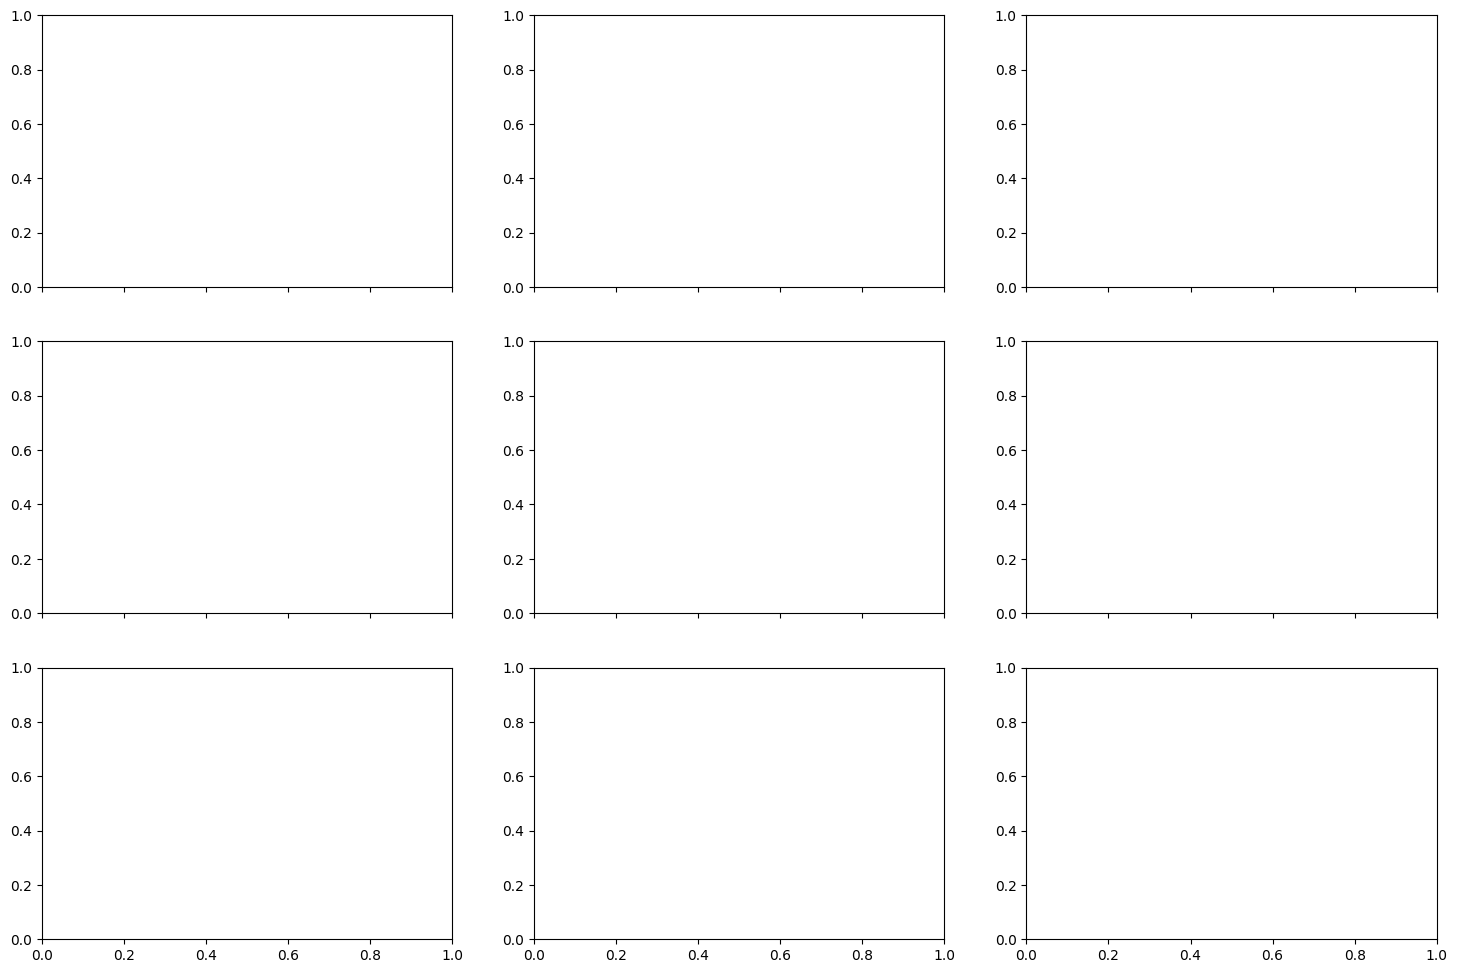

In [80]:
# Lista com os nomes das 9 regi√µes (colunas de carga)
regioes_carga = [
    'coast_carga', 'east_carga', 'far_west_carga',
    'north_carga', 'north_central_carga', 'south_central_carga',
    'southern_carga', 'west_carga', 'system_total'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gr√°fico para cada regi√£o
for i, regiao in enumerate(regioes_carga):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # T√≠tulos e est√©tica
    nome_formatado = regiao.replace('_carga', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Carga M√©dia (MW)')
    axes[i].legend(title='Esta√ß√£o', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('M√©dia Hor√°ria de Carga por Regi√£o e Esta√ß√£o (MW)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Comparativo entre temperatura vs carga ambos por estacao

In [ ]:
def comparar_temp_carga_estacoes(df, regiao_tc):
    regiao_nome = regiao_tc.replace('_tc', '')
    regiao_carga = f'{regiao_nome}_carga'

    # Agrupar dados por esta√ß√£o e hora
    df_temp = df.groupby(['estacao', 'hour'])[regiao_tc].mean().reset_index()
    df_carga = df.groupby(['estacao', 'hour'])[regiao_carga].mean().reset_index()

    estacoes = sorted(df['estacao'].dropna().unique())

    # Criar figura com 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

    # --- Gr√°fico de Temperatura ---
    sns.lineplot(data=df_temp, x='hour', y=regiao_tc, hue='estacao', palette='tab10', ax=axs[0])
    # axs[0].set_title(f'Temperatura por Esta√ß√£o - {regiao_nome.title()}')
    axs[0].set_xlabel('Hora')
    axs[0].set_ylabel('Temperatura (¬∞C)')
    axs[0].grid(True)

    # --- Gr√°fico de Carga ---
    sns.lineplot(data=df_carga, x='hour', y=regiao_carga, hue='estacao', palette='tab10',dashes=True, ax=axs[1])
    # axs[1].set_title(f'Carga por Esta√ß√£o - {regiao_nome.title()}')
    axs[1].set_xlabel('Hora')
    axs[1].set_ylabel('Carga (MW)')
    axs[1].grid(True)

    # Ajuste da legenda
    axs[1].legend_.remove()  # Remove legenda duplicada
    axs[0].legend( fontsize='small')

    # Layout final
    plt.suptitle(f'Comparativo Temperatura x Carga - {regiao_nome.title()}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


comparar_temp_carga_estacoes(df_dia_semana, 'far_west_tc')

In [10]:
tabela_equacoes(df = df , n_weekday = 1)

Hora                  avg_temp_celsius                         coast_tc  \
0      0  y = 89.36x¬≤ -2424.62x + 55507.53  y = 25.74x¬≤ -737.48x + 15144.30   
1      1  y = 89.65x¬≤ -2440.69x + 54394.81  y = 24.83x¬≤ -715.94x + 14761.71   
2      2  y = 88.05x¬≤ -2391.05x + 53296.77  y = 23.05x¬≤ -653.19x + 14054.07   
3      3  y = 87.43x¬≤ -2365.74x + 52880.95  y = 22.58x¬≤ -639.24x + 13937.15   
4      4  y = 87.37x¬≤ -2371.47x + 53486.75  y = 21.92x¬≤ -619.26x + 13980.40   
5      5  y = 87.18x¬≤ -2406.62x + 55868.94  y = 22.07x¬≤ -636.67x + 14735.61   
6      6  y = 82.09x¬≤ -2335.92x + 59186.51  y = 20.27x¬≤ -596.45x + 15296.55   
7      7  y = 80.11x¬≤ -2305.72x + 60753.66  y = 21.27x¬≤ -639.93x + 16021.37   
8      8  y = 84.08x¬≤ -2412.44x + 61668.18  y = 22.56x¬≤ -688.51x + 16590.44   
9      9  y = 87.84x¬≤ -2650.48x + 65128.78  y = 23.22x¬≤ -732.82x + 17390.56   
10    10  y = 92.77x¬≤ -2903.58x + 68193.89  y = 24.81x¬≤ -792.27x + 18070.47   
11    11  y = 95.11x¬≤ -3034.47x + 69513.23  y = 25.43x¬≤ -805.93x + 18079.36   
12    12  y = 95.78x¬≤ -3085.28x + 69818.18  y = 25.69x¬≤ -820.54x + 18254.38   
13    13  y = 95.25x¬≤ -3075.15x + 69527.49  y = 24.47x¬≤ -753.91x + 17535.74   
14    14  y = 92.41x¬≤ -2947.16x + 67809.96  y = 22.78x¬≤ -663.82x + 16412.91   
15    15  y = 86.65x¬≤ -2701.74x + 65195.00  y = 19.12x¬≤ -468.26x + 13976.94   
16    16  y = 81.83x¬≤ -2505.62x + 63649.16  y = 18.01x¬≤ -406.20x + 13190.26   
17    17  y = 79.55x¬≤ -2454.04x + 64468.02  y = 19.19x¬≤ -494.95x + 14717.96   
18    18  y = 77.40x¬≤ -2415.89x + 65581.67  y = 23.00x¬≤ -700.40x + 17332.59   
19    19  y = 75.31x¬≤ -2315.71x + 64808.76  y = 22.51x¬≤ -669.69x + 16975.84   
20    20  y = 80.08x¬≤ -2384.98x + 64232.69  y = 25.29x¬≤ -746.62x + 17309.56   
21    21  y = 85.75x¬≤ -2409.02x + 62230.92  y = 25.44x¬≤ -716.56x + 16536.28   
22    22  y = 87.70x¬≤ -2397.50x + 59713.64  y = 25.14x¬≤ -703.86x + 15897.90   
23    23  y = 89.07x¬≤ -2418.64x + 57547.94  y = 25.60x¬≤ -724.50x + 15485.30   

                          east_tc                   far_west_tc  \
0   y = 3.50x¬≤ -101.87x + 2086.66  y = 2.14x¬≤ -52.82x + 6473.50   
1    y = 3.30x¬≤ -96.25x + 2002.96  y = 2.20x¬≤ -52.84x + 6439.73   
2    y = 3.32x¬≤ -98.18x + 1993.72  y = 2.10x¬≤ -46.66x + 6362.85   
3    y = 3.25x¬≤ -96.84x + 1980.81  y = 1.99x¬≤ -42.78x + 6319.51   
4    y = 3.26x¬≤ -98.64x + 2034.75  y = 1.98x¬≤ -41.48x + 6295.49   
5   y = 3.24x¬≤ -100.47x + 2147.52  y = 1.85x¬≤ -39.58x + 6306.06   
6    y = 2.92x¬≤ -95.19x + 2298.57  y = 1.62x¬≤ -35.68x + 6374.58   
7    y = 2.84x¬≤ -93.57x + 2351.84  y = 1.35x¬≤ -28.75x + 6364.89   
8    y = 3.09x¬≤ -99.07x + 2377.52  y = 2.07x¬≤ -47.89x + 6509.62   
9   y = 3.58x¬≤ -119.22x + 2592.76  y = 2.05x¬≤ -48.85x + 6611.81   
10  y = 3.77x¬≤ -127.86x + 2699.85  y = 1.83x¬≤ -43.61x + 6590.02   
11  y = 3.93x¬≤ -133.45x + 2748.66  y = 1.82x¬≤ -43.34x + 6557.76   
12  y = 4.00x¬≤ -134.33x + 2723.02  y = 1.74x¬≤ -43.65x + 6576.00   
13  y = 4.13x¬≤ -138.67x + 2753.11  y = 1.52x¬≤ -35.54x + 6445.20   
14  y = 4.11x¬≤ -138.93x + 2771.11  y = 1.29x¬≤ -28.15x + 6317.34   
15  y = 3.89x¬≤ -130.30x + 2694.65   y = 0.64x¬≤ -0.95x + 5975.21   
16  y = 3.64x¬≤ -119.60x + 2604.89    y = 0.55x¬≤ 4.22x + 5843.01   
17  y = 3.41x¬≤ -113.04x + 2610.94   y = 0.76x¬≤ -5.31x + 5852.14   
18  y = 3.17x¬≤ -104.27x + 2565.35  y = 1.17x¬≤ -27.77x + 6121.33   
19  y = 3.09x¬≤ -100.40x + 2521.63  y = 1.36x¬≤ -39.41x + 6269.26   
20  y = 3.54x¬≤ -111.64x + 2551.29  y = 1.66x¬≤ -54.06x + 6447.42   
21  y = 3.73x¬≤ -111.93x + 2456.72  y = 2.05x¬≤ -63.16x + 6608.77   
22  y = 3.96x¬≤ -117.57x + 2376.87  y = 2.11x¬≤ -58.76x + 6586.88   
23  y = 3.68x¬≤ -107.33x + 2205.40  y = 2.34x¬≤ -63.80x + 6592.30   

                        north_tc                  north_central_tc  \
0   y = 2.19x¬≤ -48.88x + 1436.16   y = 29.17x¬≤ -807.08x + 15670.57   
1   y = 2.12x¬≤ -47.71x + 1405.28   y = 29.53x¬≤ -821.44x + 15325.52   
2   y = 2.11x¬≤ -47.76x + 1383.65   y = 28

# Grid de gr√°ficos por regiao e parametrizando uma hora por vez

In [ ]:
grid_graficos(df= df, hour=0, weekday= 1)

# DF long
- aqui ja criarei a coluna da temperatura ponderada pela populacao do condado , ser√° usado apenas no teste 2
- a tabela ja servir√° para os teste 1 e 2
- a tabela 3 usar√° o df original

In [6]:
# dados da populacao do texas
pop_texas = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/√Årea de Trabalho/serena-tcc/dados/pop_texas.csv')
pop_texas = pop_texas.drop_duplicates(keep = 'first', subset=['COUNTY'])

In [7]:
# Aqui transforma a tabela em long e ja vem com a temp_ponderada pela popula√ß√£o
df_pond_long = preparar_df_long_com_ponderada(df, pop_texas)

In [8]:
df_pond_long

interval_start_utc  hour  weekday  temp_ponderada_pop regiao  \
0       2023-08-31 19:00:00    19        1           34.373786  coast   
1       2023-08-31 19:00:00    19        1           34.373786  coast   
2       2023-08-31 19:00:00    19        1           34.373786  coast   
3       2023-08-31 19:00:00    19        1           34.373786  coast   
4       2023-08-31 19:00:00    19        1           34.373786  coast   
...                     ...   ...      ...                 ...    ...   
1218691 2024-08-11 15:00:00    15        0           32.584507   west   
1218692 2024-08-11 15:00:00    15        0           32.584507   west   
1218693 2024-08-11 15:00:00    15        0           32.584507   west   
1218694 2024-08-11 15:00:00    15        0           32.584507   west   
1218695 2024-08-11 15:00:00    15        0           32.584507   west   

         temperatura       carga  
0          33.611111  15754.7002  
1          33.611111  18833.6992  
2          33.611111  18314.1992  
3          33.611111  18665.6992  
4          33.611111  15754.7002  
...              ...         ...  
1218691    37.555556   2138.3362  
1218692    37.555556   2137.1299  
1218693    37.555556   2368.1499  
1218694    37.555556   2173.3601  
1218695    37.555556   2138.3362  

[1218696 rows x 7 columns]

# Parametros gerais

In [24]:
n_weekday = 0
hour = 2

# Teste 1
- treinamento com a carga total vs media simples temperatura do estado
- usando regress√£o linear com M√≠nimos Quadrados Ordin√°rios
- PolynomialFeatures(degree=2), dados com termos quadr√°ticos

- Voc√™ transforma a vari√°vel X (temperatura m√©dia) em: 
    1 (termo constante)

    X (linear)

    X¬≤ (quadr√°tico)

- Depois ajusta a equa√ß√£o do tipo:
 y_hat = ùõΩ0 + ùõΩ1X + ùõΩ2X¬≤

-  E os coeficientes ùõΩ s√£o estimados por MQO

In [9]:
tabela1 = treinamento_media_simples(df_pond_long)
tabela1

regiao  hora                         equacao  RMSE Treino  R¬≤ Treino  \
0    coast     0  y = 26.75x¬≤ -766.52x +15317.09   783.187162   0.878253   
1    coast     1   y = -4.57x¬≤ +391.00x +5796.25  1508.066931   0.469040   
2    coast     2  y = 24.30x¬≤ -687.81x +14233.35   693.376813   0.866975   
3    coast     3  y = 23.81x¬≤ -673.72x +14087.50   724.864730   0.840113   
4    coast     4  y = 23.69x¬≤ -673.19x +14225.06   711.381717   0.829250   
..     ...   ...                             ...          ...        ...   
187   west    19     y = 1.51x¬≤ -44.67x +1642.77   141.987792   0.816121   
188   west    20     y = 1.46x¬≤ -41.66x +1604.90   122.928699   0.817896   
189   west    21     y = 1.62x¬≤ -43.69x +1571.38   113.348087   0.828243   
190   west    22     y = 1.72x¬≤ -45.39x +1513.74   105.244971   0.823547   
191   west    23     y = 1.84x¬≤ -49.22x +1474.80    98.626448   0.815948   

      RMSE Teste  R¬≤ Teste  RMSE Valida√ß√£o  R¬≤ Valida√ß√£o  CV RMSE M√©dio  \
0     703.740907  0.897121      709.880126      0.894640     708.269886   
1    1412.259980  0.511822     1452.193129      0.482935    1472.914374   
2     760.860616  0.839414      725.874953      0.854614     727.864466   
3     641.790782  0.868732      662.672317      0.860302     659.949748   
4     651.308969  0.851115      666.114625      0.843662     664.558596   
..           ...       ...             ...           ...            ...   
187   153.168099  0.789873      146.033704      0.808687     146.072438   
188   131.180558  0.798288      125.876858      0.813315     126.087632   
189   120.581255  0.811700      114.267278      0.828096     114.461771   
190   110.759007  0.811468      105.157852      0.825869     105.260077   
191   103.921430  0.803435       99.468507      0.815227      99.433204   

     CV RMSE DP  
0     78.869368  
1     78.198870  
2     63.431500  
3     79.578885  
4     62.186055  
..          ...  
187    5.760373  
188    5.080622  
189    5.785292  
190    6.406913  
191    7.320397  

[192 rows x 11 columns]

### RMSE
O que √©:
√â a raiz do erro quadr√°tico m√©dio ‚Äî ou seja, mede o qu√£o distante, em m√©dia, as previs√µes est√£o dos valores reais, na mesma unidade da vari√°vel dependente, que aqui √© MW de carga.

Como interpretar:

Um RMSE de 1523.89 MW significa que, em m√©dia, a previs√£o do modelo est√° errando a carga por cerca de 1.524 MW.

Se a carga total m√©dia do sistema estiver, por exemplo, em torno de 18.000 MW, esse erro representa aproximadamente 8,5% da carga ‚Äî o que pode ser razo√°vel ou bom, dependendo da variabilidade natural da carga.


### R¬≤
O que √©:
Indica quanto da variabilidade da carga o modelo consegue explicar com a temperatura.

Como interpretar:

Um R¬≤ de 0.825 significa que o modelo explica 82,5% da varia√ß√£o na carga el√©trica com base na temperatura.

Isso √© um valor bastante forte, principalmente se estamos usando apenas uma vari√°vel (temperatura) para prever a carga.

Em problemas reais, R¬≤ acima de 0.8 √© geralmente considerado muito bom, especialmente com s√©ries temporais ou dados ambientais.

# Teste 2
- treinamento com a carga total vs media ponderada temperatura do estado (ponderada por carga historica ou popula√ß√£o)
- a populacao ser√° de cada condado do Texas (214 condados), por que o ERCOT nao engloba tudo, quase 90%


In [10]:
tabela2 = treinamento_ponderado_por_zona_e_hora(df_pond_long)
tabela2

regiao  hora                         equacao  RMSE Treino  R¬≤ Treino  \
0    coast     0  y = 12.91x¬≤ -191.84x +10841.24   999.307874   0.801790   
1    coast     1   y = -1.25x¬≤ +209.23x +8698.23  1473.244893   0.493277   
2    coast     2  y = 12.81x¬≤ -197.57x +10442.13   889.631308   0.781015   
3    coast     3  y = 13.00x¬≤ -204.34x +10430.69   885.775829   0.761248   
4    coast     4  y = 13.05x¬≤ -209.42x +10605.94   868.828708   0.745303   
..     ...   ...                             ...          ...        ...   
187   west    19     y = 1.39x¬≤ -33.35x +1519.84   147.156612   0.802489   
188   west    20     y = 1.47x¬≤ -35.34x +1527.43   124.869636   0.812100   
189   west    21     y = 1.76x¬≤ -41.74x +1528.55   121.582623   0.802381   
190   west    22     y = 1.90x¬≤ -44.97x +1489.35   115.089406   0.788993   
191   west    23     y = 1.98x¬≤ -48.25x +1450.79   109.292169   0.773988   

      RMSE Teste  R¬≤ Teste  RMSE Valida√ß√£o  R¬≤ Valida√ß√£o  CV RMSE M√©dio  \
0     932.089609  0.819525      976.948589      0.800450     975.991331   
1    1337.242345  0.562307     1371.126945      0.539052    1387.243293   
2     935.459683  0.757256      893.667173      0.779630     894.889763   
3     805.231870  0.793360      854.529059      0.767702     852.978188   
4     783.019513  0.784810      839.678769      0.751576     837.865888   
..           ...       ...             ...           ...            ...   
187   147.489843  0.805164      151.687692      0.793587     151.711026   
188   125.638738  0.814971      128.678781      0.804912     128.767336   
189   122.690386  0.805055      125.350888      0.793131     125.452085   
190   114.895290  0.797124      118.469409      0.778994     118.419366   
191   110.328780  0.778449      111.387117      0.768294     111.247025   

     CV RMSE DP  
0     57.345757  
1    116.725941  
2     25.025588  
3     72.642642  
4     74.617921  
..          ...  
187    4.355664  
188    5.828109  
189    6.369589  
190    6.313948  
191    8.603511  

[192 rows x 11 columns]

# Teste 3
- treinamento com carga por weather_zone vs temperatura por weather zone (√© o que eu ja fiz)

In [11]:
tabela3 = treinamento_por_weather_zone_e_hora_cv(df = df)
tabela3

weather_zone  hora                         equacao  RMSE Treino  \
0          coast     0  y = 26.22x¬≤ -751.19x +15227.30   790.679255   
1          coast     1   y = -4.33x¬≤ +375.63x +5991.43  1490.702950   
2          coast     2  y = 23.92x¬≤ -678.52x +14208.36   711.575953   
3          coast     3  y = 23.39x¬≤ -663.30x +14044.64   733.045474   
4          coast     4  y = 23.03x¬≤ -654.15x +14114.06   726.539319   
..           ...   ...                             ...          ...   
187         west    19     y = 1.50x¬≤ -44.60x +1642.99   145.617716   
188         west    20     y = 1.48x¬≤ -42.23x +1607.38   124.886357   
189         west    21     y = 1.65x¬≤ -44.66x +1576.32   114.588519   
190         west    22     y = 1.76x¬≤ -46.35x +1518.61   106.785944   
191         west    23     y = 1.86x¬≤ -49.48x +1474.04   101.773582   

     R¬≤ Treino   RMSE Teste  R¬≤ Teste  RMSE Valida√ß√£o  R¬≤ Valida√ß√£o  \
0     0.873037   659.070029  0.910780      662.042813      0.901513   
1     0.470530  1254.710646  0.615542     1444.961746      0.441427   
2     0.859468   720.051023  0.848348      650.588624      0.868700   
3     0.834488   577.482539  0.890589      631.806290      0.857925   
4     0.821179   572.566255  0.877925      653.595792      0.829173   
..         ...          ...       ...             ...           ...   
187   0.810281   133.580288  0.835902      132.824561      0.830029   
188   0.816140   120.577468  0.827883      118.750269      0.818117   
189   0.828267   113.266630  0.824427      106.980103      0.831925   
190   0.823335   101.106697  0.829123      104.918690      0.812653   
191   0.809166    96.010820  0.816175       98.224688      0.811139   

     CV RMSE M√©dio   CV RMSE DP  
0       688.338827    85.327162  
1      2654.993383  2356.927499  
2       662.600488    73.206874  
3       637.944470   120.252695  
4       663.743369   113.964364  
..             ...          ...  
187     133.251637     9.895103  
188     118.438103    12.898236  
189     107.370976     9.575919  
190     106.859247     4.315483  
191     100.160933     5.712269  

[192 rows x 11 columns]

In [18]:
# tabela1.to_excel('tabela1.xlsx')
# tabela2.to_excel('tabela2.xlsx')
# tabela3.to_excel('tabela3.xlsx')

# Resumo das tabelas
- RMSE, quanto menor, melhor
- R¬≤, quanto mais pr√≥ximo de 1, melhor

In [12]:
def plotar_tabelas_teste_cv(df1, df2, df3, titulos):
    fig, axs = plt.subplots(3, 1, figsize=(12, 20))
    dfs = [df1, df2, df3]

    # Colunas que queremos manter
    colunas_desejadas = [
        'regiao', 'weather_zone', 'equacao',  # depende do seu dataframe
        'RMSE Teste', 'R¬≤ Teste',
        'CV RMSE M√©dio', 'CV RMSE DP'
    ]

    for ax, df, titulo in zip(axs, dfs, titulos):
        ax.axis('off')
        df_formatado = df.copy()

        # Manter apenas as colunas desejadas que existem no dataframe
        colunas_presentes = [col for col in colunas_desejadas if col in df_formatado.columns]
        df_formatado = df_formatado[colunas_presentes]

        # Remover casas decimais da equa√ß√£o (se existir)
        if 'equacao' in df_formatado.columns:
            df_formatado['equacao'] = df_formatado['equacao'].str.replace(
                r'([-+]?\d+)(\.\d+)?', lambda m: str(int(round(float(m.group())))), regex=True
            )

        # Formatar colunas num√©ricas com 2 casas decimais
        colunas_formatar = [col for col in df_formatado.columns if 'rmse' in col.lower() or 'r¬≤' in col.lower()]
        for col in colunas_formatar:
            df_formatado[col] = df_formatado[col].map(lambda x: f"{x:.2f}")

        # T√≠tulo da tabela
        ax.set_title(titulo, fontsize=13, pad=20, loc='center', fontweight='bold')

        # Criar tabela
        tabela = ax.table(
            cellText=df_formatado.values,
            colLabels=df_formatado.columns,
            loc='center',
            cellLoc='center',
            bbox=[0, 0, 1, 0.9]
        )
        tabela.auto_set_font_size(False)
        tabela.set_fontsize(10)
        tabela.scale(1.1, 1.2)

    plt.tight_layout()
    plt.show()



In [14]:
# plotar_tabelas_teste_cv(
#     df1=tabela1,
#     df2=tabela2,
#     df3=tabela3,
#     titulos=["Regress√£o com m√©dia simples da temperatura","Regress√£o com temperatura ponderada pela popula√ß√£o","Regress√£o por regi√£o (individual)"]
# )

# Analisando apenas RMSE

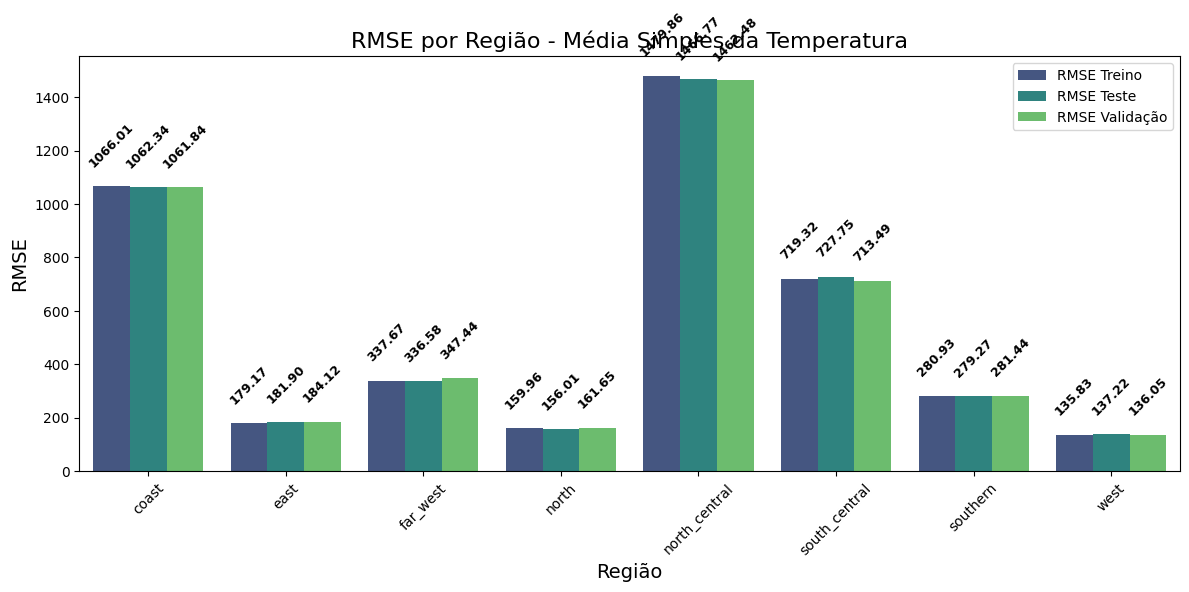

In [77]:
def plot_rmse_por_regiao(df, titulo="RMSE por Regi√£o"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Preparar os dados no formato longo
    df_meltado = df.melt(
        id_vars="regiao", 
        value_vars=["RMSE Treino", "RMSE Teste", "RMSE Valida√ß√£o"], 
        var_name="Tipo", 
        value_name="RMSE"
    )

    # Criar o gr√°fico
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_meltado, 
        x="regiao", 
        y="RMSE", 
        hue="Tipo", 
        palette="viridis",
        errorbar=None
    )

    # Remover as bordas pretas das barras
    for bar in ax.patches:
        bar.set_edgecolor("none")

    # Adicionar r√≥tulos com mais espa√ßamento acima das barras
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 12),  # dist√¢ncia aumentada para 12
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=45,
                    color='black', fontsize=9, fontweight='bold')

    # Ajustes finais do gr√°fico
    ax.set_title(titulo, fontsize=16)
    ax.set_xlabel("Regi√£o", fontsize=14)
    ax.set_ylabel("RMSE", fontsize=14)
    plt.xticks(rotation=45)
    ax.legend(title="", loc="upper right")
    plt.tight_layout()
    plt.show()

# Exemplo de chamada
plot_rmse_por_regiao(tabela1, titulo="RMSE por Regi√£o - M√©dia Simples da Temperatura")


# Analisando apenas R¬≤

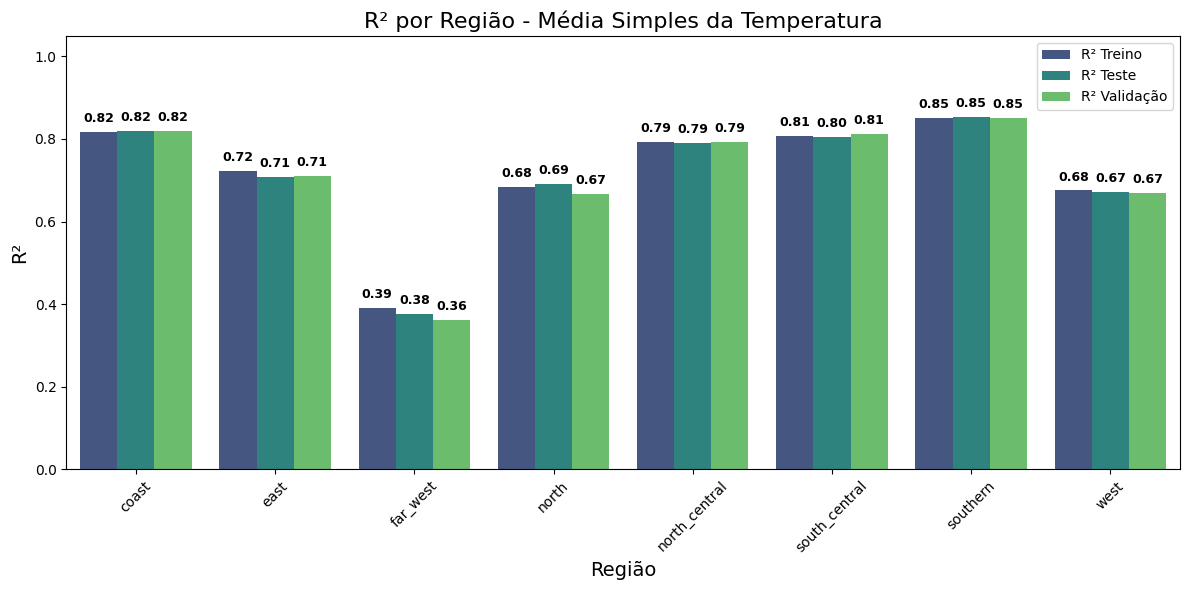

In [78]:
def plot_r2_por_regiao(df, titulo="R¬≤ por Regi√£o"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Preparar os dados no formato longo
    df_meltado = df.melt(
        id_vars="regiao", 
        value_vars=["R¬≤ Treino", "R¬≤ Teste", "R¬≤ Valida√ß√£o"], 
        var_name="Tipo", 
        value_name="R¬≤"
    )

    # Criar o gr√°fico
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_meltado, 
        x="regiao", 
        y="R¬≤", 
        hue="Tipo", 
        palette="viridis",
        errorbar=None
    )

    # Remover as bordas pretas das barras
    for bar in ax.patches:
        bar.set_edgecolor("none")

    # Adicionar os r√≥tulos acima das barras (n√£o dentro)
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 pontos acima da barra
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='black', fontsize=9, fontweight='bold')

    # Ajustes finais do gr√°fico
    ax.set_title(titulo, fontsize=16)
    ax.set_xlabel("Regi√£o", fontsize=14)
    ax.set_ylabel("R¬≤", fontsize=14)
    plt.xticks(rotation=45)
    ax.legend(title="", loc="upper right")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


plot_r2_por_regiao(tabela1, titulo="R¬≤ por Regi√£o - M√©dia Simples da Temperatura")


In [67]:
tabela1[(tabela1['regiao']=='far_west')]['R¬≤ Valida√ß√£o'].mean()

0.3604005371263168

# Analisando apenas CV

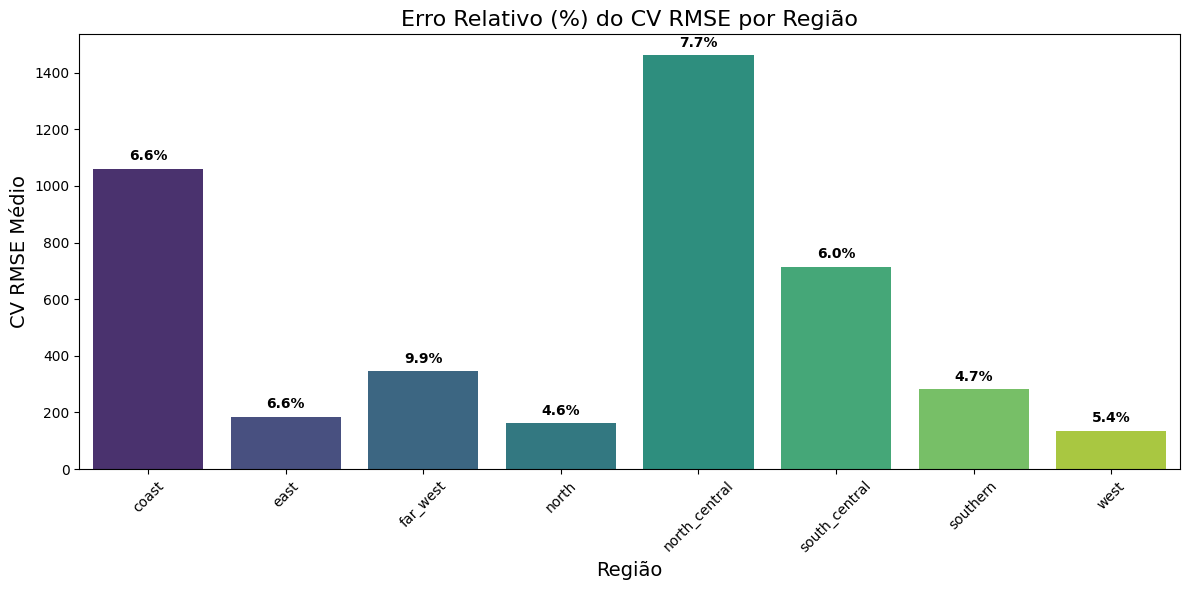

In [79]:
def plot_erro_relativo_por_regiao(df, titulo="Erro Relativo (%) do CV RMSE por Regi√£o"):
    # Agrupar os dados por regi√£o
    df_grouped = df.groupby("regiao").agg({
        'CV RMSE M√©dio': 'mean',
        'CV RMSE DP': 'mean'
    }).reset_index()

    # Calcular erro relativo (%) para cada regi√£o
    df_grouped["Erro Relativo (%)"] = (df_grouped["CV RMSE DP"] / df_grouped["CV RMSE M√©dio"]) * 100

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_grouped, x="regiao", y="CV RMSE M√©dio", palette="viridis", ci=None)

    # Adicionar texto com erro relativo (%) acima de cada barra
    for i, row in df_grouped.iterrows():
        ax.text(i, row["CV RMSE M√©dio"] + 30, f'{row["Erro Relativo (%)"]:.1f}%', 
                color='black', ha="center", weight="bold")

    # Finalizar gr√°fico
    plt.title(titulo, fontsize=16)
    plt.xlabel("Regi√£o", fontsize=14)
    plt.ylabel("CV RMSE M√©dio", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    
plot_erro_relativo_por_regiao(tabela1, titulo="Erro Relativo (%) do CV RMSE por Regi√£o")


In [93]:
df_pond_long[df_pond_long['regiao']=='coast']['carga'].mean()


print(f"df: {df['coast_carga'].mean()}")
print(f"df_long: {df_pond_long[df_pond_long['regiao']=='coast']['carga'].mean()}")


df: 13620.767550500817
df_long: 13715.321477667276
